# Unit Testing Optimisation

## Importing the Packages

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.use("pgf")
%matplotlib inline
plt.plot([1, 2, 3])
mpl.use("pgf")
mpl.rcParams.update(
    {
        "pgf.texsystem": "lualatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.preamble": "\n".join(
            [
                r"\usepackage{bm}",
                r"\usepackage{mathtools}",
                r"\usepackage{amsmath}",
                r"\DeclarePairedDelimiter\abs{\lvert}{\rvert}%",
                r"\DeclarePairedDelimiter\norm{\lVert}{\rVert}",
                r"\makeatletter",
                r"\let\oldabs\abs",
                r"\def\abs{\@ifstar{\oldabs}{\oldabs*}}",
                r"\let\oldnorm\norm",
                r"\def\norm{\@ifstar{\oldnorm}{\oldnorm*}}",
                r"\makeatother",
                r"\usepackage[dvipsnames]{xcolor}", 
                r"\definecolor{myred}{RGB}{205, 108, 46}",
            ]
        ),
        "font.serif": ["Computer Modern Roman"],
    }
)

import matplotlib.font_manager
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Divider, Size, make_axes_locatable
import matplotlib.patches as mpatches
from mpl_toolkits import mplot3d
import matplotlib.cm as cm

import numpy as np
import scipy as sc
import scipy.io as io
from scipy.stats import multivariate_normal
from functools import partial

import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, random, lax, value_and_grad, tree_multimap, tree_map
import jax.example_libraries.optimizers as jeo

import time

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

## Defining SE Covariance

In [3]:
def Squared_exp(I, J, Sigma_f, Ell):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2.0*Ell**2))

In [4]:
Vec_SE = jit(vmap(vmap(Squared_exp, in_axes=[None,0,None,None]),in_axes=[0,None,None,None]))

## Creating Test Data

In [5]:
key = random.PRNGKey(1)
key, *subkeys = random.split(key, 4)

In [6]:
# Time resolution
time_bin = 0.005

### Input Spike Train

In [7]:
subkeyx = subkeys[-1]

# Time horizon for input data
x_maxt = 2.5

# Maximum index of input data
k = np.floor(x_maxt/time_bin).astype(np.int64)

xtime = np.linspace(0.0, x_maxt, k + 1)

xtest = random.bernoulli(subkeyx, 0.1, (k+1,)).astype(np.float64)

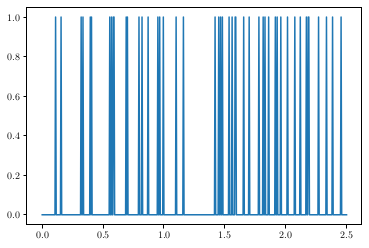

In [8]:
plt.plot(xtime, xtest)

### True Filter

In [9]:
subkeyf = subkeys[-2]

# Filter horizon
f_maxt = 0.25

# Maximum index of filter data
n = np.floor(f_maxt/time_bin).astype(np.int64)
ftime = np.linspace(0.0, f_maxt, n + 1)

# True filter mean
mu_true = np.zeros(n + 1)
# True filter variance
sig_true = 1.0
# True filter length scale
ell_true = 0.02

cov_true = Vec_SE(ftime, ftime, sig_true, ell_true)
chol_true = np.linalg.cholesky(cov_true + 1e-6 * np.eye(n + 1))

ftrue = mu_true + chol_true @ random.normal(subkeyf, (n + 1, ))

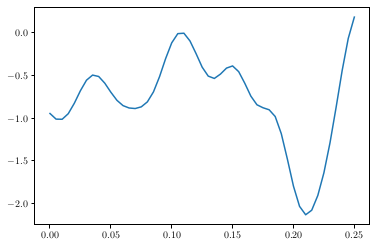

In [10]:
plt.plot(ftime, ftrue)

### True Noise

In [11]:
subkeyn = subkeys[-3]

# True noise variance
sign_true = 0.05

# Noise vector
noise_vec = sign_true * random.normal(subkeyn, (k + 1,))

### Output

In [12]:
# Padding and applying the FFT
xpad = np.append(xtest, np.zeros(n))
fpad = np.append(ftrue, np.zeros(k))

x_fft = np.fft.rfft(xpad)
f_fft = np.fft.rfft(fpad)

fftmul = x_fft * f_fft

ynonoise = np.fft.irfft(fftmul, n + k + 1)[:k + 1]

ytest = ynonoise + noise_vec
ytime = np.linspace(0.0, x_maxt, k + 1)

In [13]:
# Showing equals the raw convolution
yffttest = np.convolve(xtest, ftrue)[:k + 1] + noise_vec

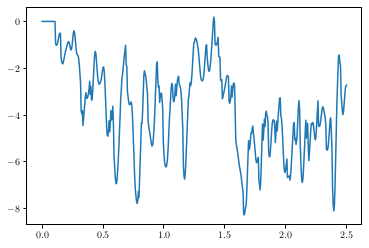

In [14]:
plt.plot(ytime, ynonoise)

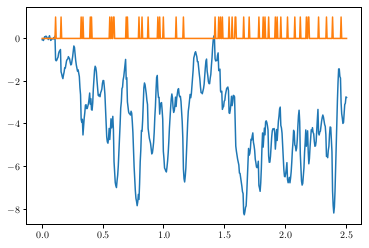

In [15]:
plt.plot(ytime, ytest)
plt.plot(xtime, xtest)

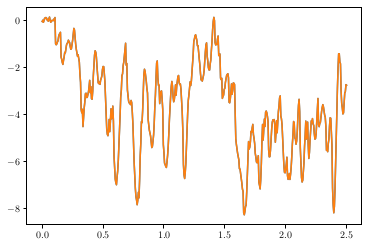

In [16]:
plt.plot(ytime, yffttest)
plt.plot(ytime, ytest)

## Variational Inference

### ELBO

#### Kl Divergence Term

In [17]:
@jit
def KL_Term(L_Matrix, V_Vector, M):
  return 0.5 * (- jnp.sum(jnp.log(jnp.diag(L_Matrix) ** 2)) + \
                jnp.sum(L_Matrix ** 2) + jnp.sum(V_Vector ** 2) - M)

#### Log-Likelihood

In [18]:
@partial(jit, static_argnums = (2, 3, ))
def Log_Likelihood(F_Pad, Sigma_n, N, K, Y_Test, X_Fft):

  F_Fft = jnp.fft.rfft(F_Pad)

  Mean = jnp.fft.irfft(X_Fft * F_Fft, N + K + 1)[: K + 1]
  
  return - 0.5 * ((K + 1) * jnp.log(2 * jnp.pi * Sigma_n ** 2) + \
                  jnp.sum((Y_Test - Mean)**2)/(Sigma_n ** 2))

In [19]:
Vec_LL = jit(vmap(Log_Likelihood, in_axes = [1, None, None, None, None, None]),
             static_argnums = (2,3,))

#### Expected Log-Likelihood

In [20]:
@partial(jit, static_argnums = range(6,10))
def Expected_Term(Sigma_f, Ell, Sigma_n, Z_Vector, V_Vector, L_Matrix, Number_F,
                  M, N, K, Y_Test, X_Fft, F_Time, Subkey):

  K_MM = Vec_SE(Z_Vector, Z_Vector, Sigma_f, Ell)
  K_MN = Vec_SE(Z_Vector, F_Time, Sigma_f, Ell)
  C = jnp.linalg.cholesky(K_MM + 1e-6 * jnp.eye(M)) 
  K_NN = Vec_SE(F_Time, F_Time, Sigma_f, Ell)
  
  B = jsc.linalg.solve_triangular(C, K_MN, lower = True)

  BT = B.T

  Mu_q = B.T @ V_Vector

  V_q = K_NN + BT @ (L_Matrix @ L_Matrix.T - jnp.eye(M)) @ B

  Chol_Vq = jnp.linalg.cholesky(V_q + 1e-6 * jnp.eye(N + 1))

  F_Samples = Mu_q + Chol_Vq @ random.normal(Subkey, (N + 1, Number_F))

  F_Samples = jnp.vstack((F_Samples, jnp.zeros((K, Number_F))))

  Likelihoods = Vec_LL(F_Samples, Sigma_n, N, K, Y_Test, X_Fft)

  return jnp.mean(Likelihoods)

In [21]:
test_number_f = 100
test_m = int(1000)
test_key = random.PRNGKey(0)
test_sigma_f = 1.0
test_ell_f = 0.01
test_sigma_n = 0.05
test_z_m = np.linspace(0.0, ftime[-1], test_m)
test_v_m = np.zeros(test_m).reshape((test_m, 1))
test_l_mm = np.eye(test_m)

In [22]:
print(Expected_Term(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m, test_l_mm, test_number_f, test_m, n, k, ytest, x_fft, ftime, test_key))

-2429306.12735477


#### ELBO

In [23]:
@partial(jit, static_argnums = range(7, 11))
def Neg_ELBO(Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, Number_F,
         M, N, K, Y_Test, X_Fft, F_Time, Subkey):

  Square_Frac = Z_Fractions ** 2.0
  Z_Vector = ((Square_Frac) / jnp.max(Square_Frac)) * F_Time[-1]

  D = jnp.diag(jnp.exp(L_Diag))

  L_Matrix = (D + jnp.zeros((M, M))).at[jnp.tril_indices(M, -1)].set(L_ODiag)

  KL = KL_Term(L_Matrix, V_Vector, M)
  Exp = Expected_Term(Sigma_f, Ell, Sigma_n, Z_Vector, V_Vector, L_Matrix,
                      Number_F, M, N, K, Y_Test, X_Fft, F_Time, Subkey)
  
  return (KL-Exp)/(K + 1)

In [24]:
test_number_f = 100
test_m = 200
test_key = random.PRNGKey(0)
test_sigma_f = 2.0
test_ell_f = 0.7
test_sigma_n = 0.01
test_z_m = np.linspace(0.0, ftime[-1], test_m)
test_v_m = 5.0 * np.ones((test_m, 1))
test_l_diag = np.ones(test_m)
test_l_odiag = np.tril(np.zeros((test_m, test_m)), -1)[np.tril_indices(test_m, -1)]

In [25]:
print(Neg_ELBO(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m, test_l_diag, test_l_odiag, test_number_f, test_m, n, k, ytest, x_fft, ftime, test_key))

53677465.102012806


In [26]:
Grad_Bound = jit(value_and_grad(Neg_ELBO, argnums = range(7)), static_argnums = range(7, 11))

### Optimiser

#### Sub-function Definitions

#### Adam Function Definition

In [36]:
def AdamOpt(Init_Params, X_Fft, Y_Test, F_Time, M, N, K, Num_Fs,              
                        Coarse_Schedule = [400, 400, 700], Mid_Schedule = [13500],
                        Fine_Iters = 5000):
  
  """
  Function implementing the Adam optimiser loop.
  """
  ELBO_History = np.zeros(20000)
  Step = 0
  Key = random.PRNGKey(1)
  Key, Subkey = random.split(Key)
  Params = Init_Params

  Opt_InitC, Opt_UpdateC, Get_ParamsC = jeo.adam(1e-2)
  Opt_InitM, Opt_UpdateM, Get_ParamsM = jeo.adam(1e-3)
  Opt_InitF, Opt_UpdateF, Get_ParamsF = jeo.adam(1e-4)

  for i in range(len(Coarse_Schedule)):
    OptState = Opt_InitC(Params)
    for j in range(Coarse_Schedule[i]):
      print(Step)
      Value, Grads = Grad_Bound(*Params, Num_Fs,
                                    M, N, K, Y_Test, X_Fft, F_Time, Subkey)
      OptState = Opt_UpdateC(j, Grads, OptState)
      Params = Get_ParamsC(OptState)
      Key, Subkey = random.split(Key)
      ELBO_History[Step] = -Value
      Step += 1

  for i in range(len(Mid_Schedule)):
    OptState = Opt_InitM(Params)
    for j in range(Mid_Schedule[i]):
      print(Step)
      Value, Grads = Grad_Bound(*Params, Num_Fs,
                                    M, N, K, Y_Test, X_Fft, F_Time, Subkey)
      OptState = Opt_UpdateM(j, Grads, OptState)
      Params = Get_ParamsM(OptState)
      Key, Subkey = random.split(Key)
      ELBO_History[Step] = -Value
      Step += 1

  OptState = Opt_InitF(Params)
  for j in range(Fine_Iters):
    print(Step)
    Value, Grads = Grad_Bound(*Params, Num_Fs,
                                  M, N, K, Y_Test, X_Fft, F_Time, Subkey)
    OptState = Opt_UpdateF(j, Grads, OptState)
    Params = Get_ParamsF(OptState)
    Key, Subkey = random.split(Key)
    ELBO_History[Step] = -Value
    Step += 1

  return Params, ELBO_History 

In [37]:
key = random.PRNGKey(4)

# Initialising the parameters

# Generative parameters
isigma_f = 2.0
iell = 0.03
isigma_n = 0.05

# Varitiational parameters
num_ind = 30
iz_vector = jnp.sqrt(jnp.linspace(0.00,1.0, num_ind))
key, *subkeys = random.split(key, 4)
iv_vector = (jnp.zeros(num_ind) + 0.01 * random.normal(subkeys[-3], (num_ind,))).reshape((num_ind, 1))
il_diag = jnp.zeros(num_ind) + 0.01 * random.normal(subkeys[-2], (num_ind,))
il_odiag = jnp.zeros(int((num_ind ** 2 - num_ind) / 2)) + \
            0.1 * random.normal(subkeys[-1], (int((num_ind ** 2 - num_ind) / 2),))
num_f = 100

# Random number generator
opt_key = random.PRNGKey(1)
opt_key, opt_subkey = random.split(opt_key)

params = (isigma_f, iell, isigma_n, iz_vector, iv_vector, il_diag, il_odiag)
consparams = (num_ind, n, k, ytest, x_fft, ftime)

In [38]:
fparams, elbo_history = AdamOpt(params, x_fft, ytest, ftime, num_ind, n, k, num_f)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
%%timeit
fparams, elbo_history = AdamOpt(params, x_fft, ytest, ftime, num_ind, n, k, num_f)

43 s ± 1.23 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
print(Neg_ELBO(*params, num_f, *consparams, opt_subkey))

13944.549665498822


In [40]:
print(Neg_ELBO(*fparams, num_f, *consparams, opt_subkey))

-1.2778925731959707


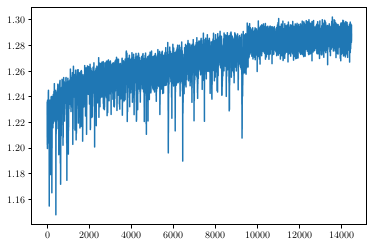

In [41]:
plt.plot(elbo_history[5500:])

In [42]:
fsigma_f, fell, fsigma_n, fz_fracs, fv_vector, fl_diag, fl_odiag = fparams
fv_vector = fv_vector.flatten()
iv_vector = iv_vector.flatten()

In [43]:
print(fsigma_f)

0.8037008211257166


In [44]:
print(fell)

-0.022239537497189637


In [45]:
print(fsigma_n)

0.057021918627663266


In [46]:
fsquares = fz_fracs ** 2
fz_vector = ((fsquares) / jnp.max(fsquares)) * ftime[-1]

In [47]:
d = np.diag(np.exp(fl_diag))

fl_matrix = d + np.zeros(num_ind)
fl_matrix[np.tril_indices(num_ind, -1)] = fl_odiag

## Variational Predictions

In [48]:
fpred_points = ftime.copy()

In [49]:
ikmm = Vec_SE(iz_vector, iz_vector, isigma_f, iell)
icpred = np.linalg.cholesky(ikmm + 1e-6 * np.eye(num_ind))
ikzast = Vec_SE(iz_vector, fpred_points, isigma_f, iell)
ibast = sc.linalg.solve_triangular(icpred, ikzast, lower = True)
icov_pred = Vec_SE(fpred_points, fpred_points, isigma_f, iell) + \
           ibast.T @ (fl_matrix @ fl_matrix.T - np.eye(num_ind)) @ ibast
imean_pred = iv_vector @ ibast

In [50]:
kmm = Vec_SE(fz_vector, fz_vector, fsigma_f, fell)
cpred = np.linalg.cholesky(kmm + 1e-6 * np.eye(num_ind))
kzast = Vec_SE(fz_vector, fpred_points, fsigma_f, fell)
bast = sc.linalg.solve_triangular(cpred, kzast, lower = True)
cov_pred = Vec_SE(fpred_points, fpred_points, fsigma_f, fell) + \
           bast.T @ (fl_matrix @ fl_matrix.T - np.eye(num_ind)) @ bast
mean_pred = fv_vector @ bast

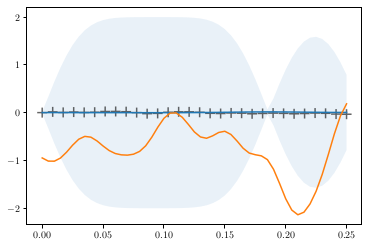

In [51]:
plt.plot(fpred_points, imean_pred)
plt.plot(ftime, ftrue)
is2 = np.sqrt(np.diag(icov_pred))
ifill = (imean_pred - is2, imean_pred + is2)
plt.fill_between(fpred_points, *ifill, alpha = 0.1)
isquares = iz_vector ** 2
izvec = ((isquares) / jnp.max(isquares)) * ftime[-1]
plt.scatter(izvec, iv_vector @ icpred.T, s = 100, marker = '+', c='k', alpha = 0.6)

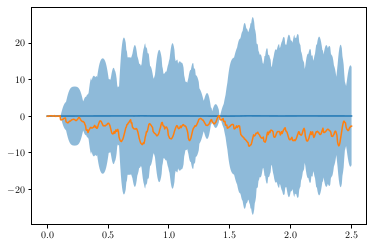

In [52]:
plt.plot(ytime, np.convolve(xtest, imean_pred)[: k + 1])
plt.plot(ytime, ytest)   
plt.fill_between(ytime, np.convolve(xtest, imean_pred - 2*is2)[: k + 1] - 2* isigma_n,
                    np.convolve(xtest, imean_pred + 2*is2)[: k + 1] + 2* isigma_n, alpha = 0.5)                 

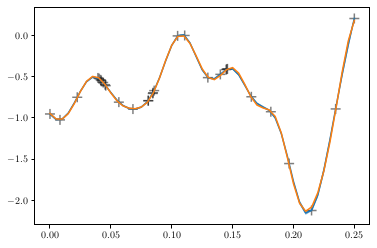

In [53]:
plt.plot(fpred_points, mean_pred)
plt.plot(ftime, ftrue)
s2 = np.sqrt(np.diag(cov_pred))
fill = (mean_pred - 2*s2, mean_pred + 2*s2)
plt.fill_between(fpred_points, *fill, alpha = 0.6)
plt.scatter(fz_vector, fv_vector @ cpred.T, s = 100, marker = '+', c='k', alpha = 0.5)

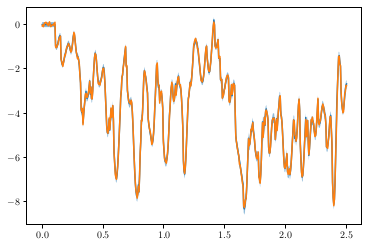

In [54]:
plt.plot(ytime, np.convolve(xtest, mean_pred)[: k + 1])
plt.plot(ytime, ytest)
plt.fill_between(ytime, np.convolve(xtest, mean_pred - 2*s2)[: k + 1] - 2* fsigma_n,
                    np.convolve(xtest, mean_pred + 2*s2)[: k + 1] + 2* fsigma_n, alpha = 0.5)                  